# MySQL Database Administration

In [1]:
import sys
utils = '/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/utils'
sys.path.insert(0, utils)

In [2]:
from sql import connect # utility functions for connecting to MySQL

import pandas as pd
import geopandas as gpd
from pathlib import Path

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
proj_dir = Path("../../..")

In [7]:
# Create a connection object to the MySQL database
# conn = connect.Connect(str(proj_dir / "Methods/2.Data/DBManagement/mysql_config.ini"))
conn = connect.Connect(str(proj_dir / ".env/mysql_config.ini"))
connection = conn.conn
cursor = conn.conn.cursor()

Connecting to MySQL database...
Connection established.


In [4]:
# CREATE SCHEMA IF NOT EXISTS `hydrothermal_history` DEFAULT CHARACTER SET utf8

## Basins

### Create new Basins table if it doesnt exist

In [5]:
# turn off foreign key checks
cursor.execute("SET FOREIGN_KEY_CHECKS = 0")

query = """
CREATE TABLE IF NOT EXISTS `Basins` (
  `BasinID` int NOT NULL AUTO_INCREMENT,
  `Prefix` varchar(45) NOT NULL DEFAULT 'BAS',
  `Name` varchar(255) NOT NULL,
  `DrainageAreaSqKm` float DEFAULT NULL COMMENT 'Drainage area of the Basin in square-kilometers',
  `MajorRiverID` int DEFAULT NULL,
  `geometry` geometry NOT NULL /*!80003 SRID 4326 */,
  PRIMARY KEY (`BasinID`),
  UNIQUE KEY `BasinID_UNIQUE` (`BasinID`),
  KEY `Fk_MajorRiver` (`MajorRiverID`),
  CONSTRAINT `Fk_MajorRiver` FOREIGN KEY (`MajorRiverID`) REFERENCES `Rivers` (`RiverID`) ON DELETE SET NULL ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)

# turn on foreign key checks
cursor.execute("SET FOREIGN_KEY_CHECKS = 1")

### Add new Basins

In [6]:
# Load basin shapefile
basins_shp = Path('../../Data/GIS/shapefiles/CRBSingle.shp')
basins_gdf = gpd.read_file(basins_shp)
basins_gdf = basins_gdf.to_crs(epsg=4326) # convert to WGS84. This is the CRS used by the database
# basins_gdf.head()

In [7]:
a = basins_gdf['geometry'][0].wkt

In [8]:
# Insert basin data into the table if the entry doesn't already exist
for i, row in basins_gdf.iterrows():
    query = f"""
    INSERT INTO Basins (Name, DrainageAreaSqKm, geometry)
    SELECT '{row['Name']}', {row['AreaSqKm']}, ST_GeomFromText('{row['geometry'].wkt}', 4326, 'axis-order=long-lat')
    WHERE NOT EXISTS (SELECT * FROM Basins WHERE Name = '{row['Name']}')
    """
    
    cursor.execute(query)
    conn.conn.commit()

    # # Update the MajorRiverID column if the river exists in the Rivers table
    # query2 = f"""
    # UPDATE Basins
    # SET MajorRiverID = (SELECT RiverID FROM Rivers WHERE Name = '{row['MajorRiver']}')
    # WHERE Name = '{row['Name']}'
    # """

    # cursor.execute(query2)
    # conn.conn.commit()


### Retrieve basin geometry

<Axes: >

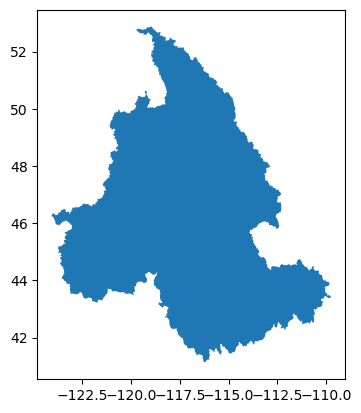

In [9]:
# Retrieve basin geometry from the database
cursor.execute("SELECT BasinID, Name, ST_AsText(geometry, 'axis-order=long-lat'), ST_SRID(geometry) AS SRID FROM basins")
basins = cursor.fetchall()
basins = pd.DataFrame(basins, columns=['basin_id', 'basin_name', 'geometry', 'srid'])

basins['geometry'] = gpd.GeoSeries.from_wkt(basins['geometry'])
basins = gpd.GeoDataFrame(basins, geometry='geometry')
basins = basins.set_crs(epsg=basins['srid'][0])
basins.plot()

## Rivers

### Create new Rivers table if it doesn't exist

In [10]:
query = """
CREATE TABLE IF NOT EXISTS `Rivers` (
  `RiverID` INT NOT NULL AUTO_INCREMENT,
  `Prefix` varchar(45) NOT NULL DEFAULT 'RIV',
  `Name` varchar(255) DEFAULT NULL,
  `LengthKm` float DEFAULT NULL COMMENT 'Length of the river in kilometers',
  `WidthM` float DEFAULT NULL COMMENT 'Width in meters',
  `BasinID` int DEFAULT NULL COMMENT 'ID for the basin in which this river lies',
  `geometry` geometry NOT NULL /*!80003 SRID 4326 */,
  PRIMARY KEY (`RiverID`),
  UNIQUE KEY `RiverID_UNIQUE` (`RiverID`),
  KEY `Fk_Basin` (`BasinID`),
  CONSTRAINT `Fk_Basin` FOREIGN KEY (`BasinID`) REFERENCES `Basins` (`BasinID`) ON DELETE SET NULL ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)


### Add new Rivers

In [11]:
# Load river shapefile
rivers_shp = Path('../../Data/GIS/shapefiles/ColumbiaTributaries.shp')
rivers_gdf = gpd.read_file(rivers_shp)
rivers_gdf = rivers_gdf.to_crs(epsg=4326) # convert to WGS84. This is the CRS used by the database
# rivers_gdf.head(60)

In [12]:
# for i, row in rivers_gdf.iterrows():
#     print(i, row['GNIS_Name'], row['geometry'].wkt)

In [13]:
# Insert river data into the table if the entry doesn't already exist
for i, row in rivers_gdf.iterrows():
    query = f"""
    INSERT INTO Rivers (Name, LengthKm, geometry)
    SELECT '{row['GNIS_Name']}', {row['LengthKM']}, ST_GeomFromText('{row['geometry'].wkt}', 4326, 'axis-order=long-lat')
    WHERE NOT EXISTS (SELECT * FROM Rivers WHERE Name = '{row['GNIS_Name']}')
    """
    
    cursor.execute(query)
    conn.conn.commit()

    # # Update the BasinID column if the basin exists in the Basins table
    # query2 = f"""
    # UPDATE Rivers
    # SET BasinID = (SELECT BasinID FROM Basins WHERE Name = '{row['Basin']}')
    # WHERE Name = '{row['GNIS_Name']}'
    # """
    query2 = f"""
    UPDATE Rivers
    SET BasinID = (SELECT BasinID FROM Basins WHERE Name = '{row['Basin']}'), LengthKm = {row['LengthKM']}
    WHERE Name = "{row['GNIS_Name']}"
    """

    cursor.execute(query2)
    conn.conn.commit()

In [14]:
# Update the MajorRiverID column if the river exists in the Rivers table
for i, row in basins_gdf.iterrows():
    query = f"""
    UPDATE Basins
    SET MajorRiverID = (SELECT RiverID FROM Rivers WHERE Name = '{row['MajorRiver']}')
    WHERE Name = '{row['Name']}'
    """

    cursor.execute(query)
    conn.conn.commit()


## Dams

### Create a new Dam table if it doesn't exist

In [15]:
query = """
CREATE TABLE IF NOT EXISTS `Dams` (
  `DamID` int NOT NULL AUTO_INCREMENT,
  `Prefix` varchar(45) NOT NULL DEFAULT 'DAM',
  `Name` varchar(255) NOT NULL,
  `Reservoir` varchar(255) DEFAULT NULL,
  `AltName` varchar(255) DEFAULT NULL,
  `RiverID` int DEFAULT NULL,
  `BasinID` int DEFAULT NULL,
  `AdminUnit` varchar(255) DEFAULT NULL,
  `Country` varchar(255) DEFAULT NULL,
  `Year` year DEFAULT NULL,
  `AreaSqKm` float DEFAULT NULL,
  `CapacityMCM` float DEFAULT NULL,
  `DepthM` float DEFAULT NULL,
  `ElevationMASL` int DEFAULT NULL,
  `MainUse` varchar(255) DEFAULT NULL,
  `LONG_DD` float DEFAULT NULL,
  `LAT_DD` float DEFAULT NULL,
  `DamGeometry` point DEFAULT NULL COMMENT 'Point geometry for the dam',
  `ReservoirGeometry` polygon DEFAULT NULL COMMENT 'Polygon geometry for the reservoir',
  PRIMARY KEY (`DamID`),
  UNIQUE KEY `DamID_UNIQUE` (`DamID`),
  KEY `Fk_river_dams` (`RiverID`),
  KEY `Fk_basin_dams` (`BasinID`),
  CONSTRAINT `Fk_basin_dams` FOREIGN KEY (`BasinID`) REFERENCES `Basins` (`BasinID`) ON DELETE SET NULL ON UPDATE CASCADE,
  CONSTRAINT `Fk_river_dams` FOREIGN KEY (`RiverID`) REFERENCES `Rivers` (`RiverID`) ON DELETE SET NULL ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)

In [16]:
# Load dams shapefile
dams_shp = Path('../../Data/GIS/shapefiles/CRBDams.shp')
reservoirs_shp = Path('../../Data/GIS/shapefiles/CRBReservoirs.shp')
dams_gdf = gpd.read_file(dams_shp)
dams_gdf = dams_gdf.to_crs(epsg=4326) # convert to WGS84. This is the CRS used by the database
reservoirs_gdf = gpd.read_file(reservoirs_shp)
reservoirs_gdf = reservoirs_gdf.to_crs(epsg=4326) # convert to WGS84. This is the CRS used by the database
# dams_gdf.head()
# reservoirs_gdf.head()

In [17]:
dams_gdf.fillna('', inplace=True)
reservoirs_gdf.fillna('', inplace=True)

/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_2478/1910903996.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dams_gdf.fillna('', inplace=True)
/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_2478/1910903996.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  reservoirs_gdf.fillna('', inplace=True)


In [18]:
# Insert river data into the table if the entry doesn't already exist
for i, row in dams_gdf.iterrows():
    # print(row['DAM_NAME'])
    query = f"""
    INSERT INTO Dams (Name, Reservoir, AltName, AdminUnit, Country, Year, AreaSqKm, CapacityMCM, DepthM, ElevationMASL, MainUse, LONG_DD, LAT_DD, DamGeometry)
    SELECT "{row['DAM_NAME']}", NULLIF("{row['RES_NAME']}", ''), NULLIF("{str(row['ALT_NAME'])}",''), '{row['ADMIN_UNIT']}', '{row['COUNTRY']}', {row['YEAR']}, {row['AREA_SKM']}, {row['CAP_MCM']}, {row['DEPTH_M']}, {row['ELEV_MASL']}, '{row['MAIN_USE']}', {row['LONG_DD']}, {row['LAT_DD']}, ST_PointFromText('{row['geometry'].wkt}', 4326, 'axis-order=long-lat')
    WHERE NOT EXISTS (SELECT * FROM Dams WHERE Name = "{row['DAM_NAME']}")
    """

    cursor.execute(query)
    conn.conn.commit()


    # Update the RiverID column if the river exists in the Rivers table
    query2 = f"""
    UPDATE Dams
    SET RiverID = (SELECT RiverID FROM Rivers WHERE Name = "{row['RIVER']}")
    WHERE Name = "{row['DAM_NAME']}"
    """

    cursor.execute(query2)
    conn.conn.commit()

    # Update the BasinID column if the basin exists in the Basins table
    query3 = f"""
    UPDATE Dams
    SET BasinID = (SELECT BasinID FROM Basins WHERE Name = 'Columbia River Basin')
    WHERE Name = "{row['DAM_NAME']}"
    """

    cursor.execute(query3)
    conn.conn.commit()

# Insert reservoir data into the table if the entry doesn't already exist
for i, row in reservoirs_gdf.iterrows():
    query = f"""
    UPDATE Dams
    SET ReservoirGeometry = ST_GeomFromText('{row['geometry'].wkt}', 4326, 'axis-order=long-lat')
    WHERE Name = "{row['DAM_NAME']}"
    """

    cursor.execute(query)
    conn.conn.commit()


## Reaches

### Create new Reaches table if it doesn't exist

In [19]:
# query = """
# CREATE TABLE IF NOT EXISTS `Reaches` (
#   `ReachID` int NOT NULL AUTO_INCREMENT,
#   `Prefix` varchar(45) NOT NULL DEFAULT 'REA',
#   `Name` varchar(255) DEFAULT NULL,
#   `RiverID` int DEFAULT NULL,
#   `ClimateClass` int DEFAULT NULL COMMENT 'Legend linking the numeric values in the maps to the Köppen-Geiger classes.\nThe RGB colors used in Beck et al. [2018] are provided between parentheses',
#   `Width` float DEFAULT NULL COMMENT 'Nominal Width (meters)',
#   `Width5` float DEFAULT NULL COMMENT 'Width at 5% (meters)',
#   `Width95` float DEFAULT NULL COMMENT 'Width 95% (meters)',
#   `Depth` float DEFAULT NULL COMMENT 'Nominal depth (meters)',
#   `Depth5` float DEFAULT NULL COMMENT 'Depth 5% (meters)',
#   `Depth95` float DEFAULT NULL COMMENT 'Depth 95% (meters)',
#   `geometry` geometry NOT NULL /*!80003 SRID 4326 */,
#   PRIMARY KEY (`ReachID`),
#   UNIQUE KEY `ReachID_UNIQUE` (`ReachID`),
#   KEY `Fk_river` (`RiverID`),
#   CONSTRAINT `Fk_river` FOREIGN KEY (`RiverID`) REFERENCES `Rivers` (`RiverID`) ON DELETE CASCADE ON UPDATE CASCADE
# ) ENGINE=InnoDB
# """

query = """
CREATE TABLE IF NOT EXISTS `Reaches` (
  `ReachID` int NOT NULL AUTO_INCREMENT,
  `Prefix` varchar(45) NOT NULL DEFAULT 'REA',
  `Name` varchar(255) DEFAULT NULL,
  `RiverID` int DEFAULT NULL,
  `ClimateClass` int DEFAULT NULL COMMENT 'Legend linking the numeric values in the maps to the Köppen-Geiger classes.\nThe RGB colors used in Beck et al. [2018] are provided between parentheses',
  `WidthMin` float DEFAULT NULL COMMENT 'Minimum width (meters)',
  `WidthMean` float DEFAULT NULL COMMENT 'Mean width (meters)',
  `WidthMax` float DEFAULT NULL COMMENT 'Maximum width (meters)',
  `geometry` geometry NOT NULL /*!80003 SRID 4326 */,
  PRIMARY KEY (`ReachID`),
  UNIQUE KEY `ReachID_UNIQUE` (`ReachID`),
  KEY `Fk_river` (`RiverID`),
  CONSTRAINT `Fk_river` FOREIGN KEY (`RiverID`) REFERENCES `Rivers` (`RiverID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB;
"""

# Create the table
cursor.execute(query)

### Add new Reaches

In [20]:
reaches_shp = Path('../../Data/GIS/shapefiles/flowlines_to_reaches/filteredReachLines.shp')
reaches_gdf = gpd.read_file(reaches_shp)
reaches_gdf = reaches_gdf.to_crs(epsg=4326) # convert to WGS84. This is the CRS used by the database

In [21]:
# Iinsert reach data into the table if the entry doesn't already exist
for i, row in reaches_gdf.iterrows():
    # query = f"""
    # INSERT INTO Reaches (Name, RiverID, ClimateClass, Width, Width5, Width95, Depth, Depth5, Depth95, geometry)
    # SELECT "{row['reach_id']}",(SELECT RiverID FROM Rivers WHERE Name = '{row['GNIS_Name']}'), {row['koppen']}, {row["WIDTH"]}, {row["WIDTH5"]}, {row["WIDTH95"]}, {row["DEPTH"]}, {row["DEPTH5"]}, {row["DEPTH95"]}, ST_GeomFromText('{row['geometry'].wkt}', 4326, 'axis-order=long-lat')
    # WHERE NOT EXISTS (SELECT * FROM Reaches WHERE Name = "{row['reach_id']}")
    # """

    query = f"""
    INSERT INTO Reaches (Name, RiverID, ClimateClass, WidthMin, WidthMean, WidthMax, geometry)
    SELECT "{row['reach_id']}",(SELECT RiverID FROM Rivers WHERE Name = '{row['GNIS_Name']}'), {row['koppen']}, NULLIF("{str(row['WidthMin'])}",'nan'), NULLIF("{str(row['WidthMean'])}",'nan'), NULLIF("{str(row['WidthMax'])}",'nan'), ST_GeomFromText('{row['geometry'].wkt}', 4326, 'axis-order=long-lat')
    WHERE NOT EXISTS (SELECT * FROM Reaches WHERE Name = "{row['reach_id']}")
    """
    
    try:
        cursor.execute(query)
        conn.conn.commit()
    except:
        print(query)
        break

    # cursor.execute(query)
    # conn.conn.commit()

In [22]:
# for i, row in reaches_gdf.iterrows():
#     query = f"""
#     UPDATE Reaches
#     SET Width = {row["WIDTH"]}, Width5 = {row["WIDTH5"]}, Width95 = {row["WIDTH95"]}, Depth = {row["DEPTH"]}, Depth5 = {row["DEPTH5"]}, Depth95 = {row["DEPTH95"]}
#     WHERE Name = "{row['reach_id']}"
#     """

#     cursor.execute(query)
#     conn.conn.commit()

## Timeseries Tables

In [8]:
# Create a table for the Dam Landsat Water Temperature data
query = """
CREATE TABLE IF NOT EXISTS `DamLandsatWaterTemp` (
  `ID` int NOT NULL AUTO_INCREMENT,
  `Date` date NOT NULL,
  `DamID` int DEFAULT NULL,
  `Value` float DEFAULT NULL COMMENT 'Landsat-based water temperature for reservoirs',
  PRIMARY KEY (`ID`),
  UNIQUE KEY `DamLandsatWaterTempID_UNIQUE` (`ID`),
  KEY `Fk_water_temp_dam` (`DamID`),
  CONSTRAINT `Fk_water_temp_dam` FOREIGN KEY (`DamID`) REFERENCES `Dams` (`DamID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)

# Create a table for the Reach Landsat Water Temperature data
query = """
CREATE TABLE IF NOT EXISTS `ReachLandsatWaterTemp` (
  `ID` int NOT NULL AUTO_INCREMENT,
  `Date` date NOT NULL,
  `ReachID` int DEFAULT NULL,
  `Value` float DEFAULT NULL COMMENT 'Landsat-based water temperature for reaches',
  PRIMARY KEY (`ID`),
  UNIQUE KEY `ReachLandsatWaterTempID_UNIQUE` (`ID`),
  KEY `Fk_water_temp_reach` (`ReachID`),
  CONSTRAINT `Fk_water_temp_reach` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)


# Create a table for the Reach Landsat Land Temperature data
query = """
CREATE TABLE IF NOT EXISTS `ReachLandsatLandTemp` (
  `ID` int NOT NULL AUTO_INCREMENT,
  `Date` date NOT NULL,
  `ReachID` int DEFAULT NULL,
  `Value` float DEFAULT NULL COMMENT 'Landsat-based land temperature on the reach corridor',
  PRIMARY KEY (`ID`),
  UNIQUE KEY `ReachLandsatLandTempID_UNIQUE` (`ID`),
  KEY `Fk_land_temp_reach` (`ReachID`),
  CONSTRAINT `Fk_land_temp_reach` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)


# Create a table for the Reach Landsat NDVI data
query = """
CREATE TABLE IF NOT EXISTS `ReachNDVI` (
  `ID` int NOT NULL AUTO_INCREMENT,
  `Date` date NOT NULL,
  `ReachID` int DEFAULT NULL,
  `Value` float DEFAULT NULL COMMENT 'NDVI on the reach buffer or corridor',
  PRIMARY KEY (`ID`),
  UNIQUE KEY `ReachNDVIID_UNIQUE` (`ID`),
  KEY `Fk_NDVI_reach` (`ReachID`),
  CONSTRAINT `Fk_NDVI_reach` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)

# Create a table for the Estimated water temperauter data
query = """
CREATE TABLE IF NOT EXISTS `ReachEstimatedWaterTemp` (
  `ID` int NOT NULL AUTO_INCREMENT,
  `Date` date NOT NULL,
  `ReachID` int DEFAULT NULL,
  `Value` float DEFAULT NULL COMMENT 'Estimated water temperature for reach',
  `Tag` VARCHAR(45) NOT NULL COMMENT 'SM - Semi-monthly estimate\nM - Monthly estimate',
  PRIMARY KEY (`ID`),
  UNIQUE KEY `ReachNDVIID_UNIQUE` (`ID`),
  KEY `Fk_est_water_temp_reach` (`ReachID`),
  CONSTRAINT `Fk_est_water_temp_reach` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB
"""

# Create the table
cursor.execute(query)

# # Create a table for the Reach Landsat Daily Climatology data
# query = """
# CREATE TABLE `ReachLandsatLTMDaily` (
#   `ID` int NOT NULL AUTO_INCREMENT,
#   `DayOfYear` int NOT NULL,
#   `WaterTemperature` float DEFAULT NULL COMMENT 'Mean water temperature',
#   `WaterTemperature5` float DEFAULT NULL COMMENT '5th percentile',
#   `WaterTemperature95` float DEFAULT NULL COMMENT '95th percentile',
#   `LandTemperature` float DEFAULT NULL COMMENT 'Mean',
#   `LandTemperature5` float DEFAULT NULL COMMENT '5th percentile',
#   `LandTemperature95` float DEFAULT NULL COMMENT '95th percentile land temp',
#   `ReachID` int NOT NULL,
#   PRIMARY KEY (`ID`),
#   UNIQUE KEY `ID_UNIQUE` (`ID`),
#   KEY `Fk_reachdlandsatltmdaily` (`ReachID`),
#   CONSTRAINT `Fk_reachdlandsatltmdaily` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
# ) ENGINE=InnoDB
# """

# # Create the table
# cursor.execute(query)

# # Create a table for the Reach Landsat Semi-monthly Climatology data
# query = """
# CREATE TABLE IF NOT EXISTS `ReachLandsatLTMSemiMonthly` (
#   `ID` int NOT NULL AUTO_INCREMENT,
#   `Month` int NOT NULL,
#   `DayOfMonth` int NOT NULL,
#   `WaterTemperature` float DEFAULT NULL COMMENT 'Mean water temperature',
#   `WaterTemperature5` float DEFAULT NULL COMMENT '5th percentile',
#   `WaterTemperature95` float DEFAULT NULL COMMENT '95th percentile',
#   `LandTemperature` float DEFAULT NULL COMMENT 'Mean',
#   `LandTemperature5` float DEFAULT NULL COMMENT '5th percentile',
#   `LandTemperature95` float DEFAULT NULL COMMENT '95th percentile land temp',
#   `ReachID` int NOT NULL,
#   PRIMARY KEY (`ID`),
#   UNIQUE KEY `ID_UNIQUE` (`ID`),
#   KEY `Fk_reachdlandsatltmsemimonthly` (`ReachID`),
#   CONSTRAINT `Fk_reachdlandsatltmsemimonthly` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
# ) ENGINE=InnoDB
# """

# # Create the table
# cursor.execute(query)

# # Create a table for the Reach Landsat Monthly Climatology data
# query = """
# CREATE TABLE `ReachLandsatLTMMonthly` (
#   `ID` int NOT NULL AUTO_INCREMENT,
#   `Month` int NOT NULL,
#   `WaterTemperature` float DEFAULT NULL COMMENT 'Mean water temperature',
#   `WaterTemperature5` float DEFAULT NULL COMMENT '5th percentile',
#   `WaterTemperature95` float DEFAULT NULL COMMENT '95th percentile',
#   `LandTemperature` float DEFAULT NULL COMMENT 'Mean',
#   `LandTemperature5` float DEFAULT NULL COMMENT '5th percentile',
#   `LandTemperature95` float DEFAULT NULL COMMENT '95th percentile land temp',
#   `ReachID` int NOT NULL,
#   PRIMARY KEY (`ID`),
#   UNIQUE KEY `ID_UNIQUE` (`ID`),
#   KEY `Fk_reachdlandsatltmmonthly` (`ReachID`),
#   CONSTRAINT `Fk_reachdlandsatltmmonthly` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
# ) ENGINE=InnoDB
# """

# # Create the table
# cursor.execute(query)

# Create a table for Reach Insitu Daily Temperature data
query = """
CREATE TABLE IF NOT EXISTS `ReachInsituWaterTemp` (
  `ID` int NOT NULL AUTO_INCREMENT,
  `Date` date NOT NULL,
  `ReachID` int DEFAULT NULL,
  `Value` float DEFAULT NULL COMMENT 'Insitu water temperature for reach',
  PRIMARY KEY (`ID`),
  UNIQUE KEY `ReachInsituWaterTempID_UNIQUE` (`ID`),
  KEY `Fk_insitu_water_temp_reach` (`ReachID`),
  CONSTRAINT `Fk_insitu_water_temp_reach` FOREIGN KEY (`ReachID`) REFERENCES `Reaches` (`ReachID`) ON DELETE CASCADE ON UPDATE CASCADE
) ENGINE=InnoDB
"""

### Dam Landsat Water Temperature Entries

In [24]:
# data_dir = Path("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/temp_timeseries/Landsat8/reservoirs")
# files = [f for f in data_dir.iterdir() if f.is_file()] # get the files in the directory
# filenames = [f.stem for f in files] # get the filenames without the extensions

In [25]:
# for file, filename in zip(files, filenames):
#     dam_name = ' '.join(filename.split('_')[1:])
#     data = pd.read_csv(file)
#     data.dropna(inplace=True)
#     # convert the date column to datetime YYYY-MM-DD
#     data['date'] = pd.to_datetime(data['date'])
#     data['date'] = data['date'].dt.date

#     for i, row in data.iterrows():
#         query = f"""
#         INSERT INTO DamLandsatWaterTemp (Date, DamID, Value)
#         SELECT '{row['date']}', (SELECT DamID FROM Dams WHERE Name = "{dam_name}"), {row['temp(C)']}
#         WHERE NOT EXISTS (SELECT * FROM DamLandsatWaterTemp WHERE Date = '{row['date']}' AND DamID = (SELECT DamID FROM Dams WHERE Name = "{dam_name}"))
#         """

#         cursor.execute(query)
#         conn.conn.commit()


### Reach Landsat Water Temperature Entries

In [26]:
# data_dir = Path("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/temp_timeseries/Landsat8/reaches")
# # get only files with the .csv extension
# files = [f for f in data_dir.iterdir() if f.is_file() and f.suffix == '.csv'] # get the files in the directory
# filenames = [f.stem for f in files] # get the filenames without the extensions

In [27]:
# for file, filename in zip(files, filenames):
#     reach_name = filename
#     data = pd.read_csv(file)[['date', 'watertemp(C)']]
#     data.dropna(inplace=True)
#     # convert the date column to datetime YYYY-MM-DD
#     data['date'] = pd.to_datetime(data['date'])
#     data['date'] = data['date'].dt.date

#     for i, row in data.iterrows():
#         query = f"""
#         INSERT INTO ReachLandsatWaterTemp (Date, ReachID, Value)
#         SELECT '{row['date']}', (SELECT ReachID FROM Reaches WHERE Name = "{reach_name}"), {row['watertemp(C)']}
#         WHERE NOT EXISTS (SELECT * FROM ReachLandsatWaterTemp WHERE Date = '{row['date']}' AND ReachID = (SELECT ReachID FROM Reaches WHERE Name = "{reach_name}"))
#         """

#         cursor.execute(query)
#         conn.conn.commit()

### Reach Landsat Land Temperature Entries  

In [54]:
# data_dir = Path("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/temp_timeseries/Landsat8/reaches")
# # get only files with the .csv extension
# files = [f for f in data_dir.iterdir() if f.is_file() and f.suffix == '.csv'] # get the files in the directory
# filenames = [f.stem for f in files] # get the filenames without the extensions

In [55]:
# for file, filename in zip(files, filenames):
#     reach_name = filename
#     data = pd.read_csv(file)[['date', 'landtemp(C)']]
#     data.dropna(inplace=True)
#     # convert the date column to datetime YYYY-MM-DD
#     data['date'] = pd.to_datetime(data['date'])
#     data['date'] = data['date'].dt.date

#     for i, row in data.iterrows():
#         query = f"""
#         INSERT INTO ReachLandsatLandTemp (Date, ReachID, Value)
#         SELECT '{row['date']}', (SELECT ReachID FROM Reaches WHERE Name = "{reach_name}"), {row['landtemp(C)']}
#         WHERE NOT EXISTS (SELECT * FROM ReachLandsatLandTemp WHERE Date = '{row['date']}' AND ReachID = (SELECT ReachID FROM Reaches WHERE Name = "{reach_name}"))
#         """

#         cursor.execute(query)
#         conn.conn.commit()

### Reach NDVI Entries

In [56]:
# data_dir = Path("/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-Hydrothermal History/Data/temp_timeseries/Landsat8/reaches")
# # get only files with the .csv extension
# files = [f for f in data_dir.iterdir() if f.is_file() and f.suffix == '.csv'] # get the files in the directory
# filenames = [f.stem for f in files] # get the filenames without the extensions

In [57]:
# for file, filename in zip(files, filenames):
#     reach_name = filename
#     data = pd.read_csv(file)[['date', 'NDVI']]
#     data.dropna(inplace=True)
#     # convert the date column to datetime YYYY-MM-DD
#     data['date'] = pd.to_datetime(data['date'])
#     data['date'] = data['date'].dt.date

#     for i, row in data.iterrows():
#         query = f"""
#         INSERT INTO ReachNDVI (Date, ReachID, Value)
#         SELECT '{row['date']}', (SELECT ReachID FROM Reaches WHERE Name = "{reach_name}"), {row['NDVI']}
#         WHERE NOT EXISTS (SELECT * FROM ReachNDVI WHERE Date = '{row['date']}' AND ReachID = (SELECT ReachID FROM Reaches WHERE Name = "{reach_name}"))
#         """

#         cursor.execute(query)
#         conn.conn.commit()

In [58]:
# close the connection
conn.close()

Connection closed.
